In [1]:
import tensorflow as tf
import tensorflow.keras.applications.resnet50 as 
import os
import collections
import time
import random
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.applications.resnet import preprocess_input

In [61]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299,299))
    img = preprocess_input(img)

    return img, image_path


In [10]:
image_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
image_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(image_input, hidden_layer)

In [48]:
with open("../dataset/captions.json") as jf:
    captions = json.loads(jf.read())

#Extract lstm from captions data set.
lstm_info = captions.pop("lstm_labels")
lstm_ranker = lstm_info['labels']
max_vocab_size = lstm_info['vocab_size']
max_caption_size = lstm_info['longest_caption']

#Dataset cleanup
img_name_vector = []
edited_captions = []

image_paths = list(captions.keys())
random.shuffle(image_paths)

for image_path in image_paths:
    captions_image = captions[image_path]
    captions_len = len(captions_image)
    
    for c in captions_image:
        caption = f"<start> {c} <end>"
        edited_captions.append(caption)
    
    img_name_vector.extend([f"{image_path}.jpg"] * captions_len)

train_set_size = round(len(img_name_vector) * 0.9)
test_set_size = len(img_name_vector) - train_set_size

while(img_name_vector[train_set_size] != img_name_vector[train_set_size + 1]):
    train_set_size += 1
    test_set_size -= 1

print(f"TRAIN SET SIZE: {train_set_size}.")
print(f"TEST SET SIZE: {test_set_size}.")

train_captions = edited_captions[:train_set_size]
train_image_name = img_name_vector[:train_set_size]
test_captions = edited_captions[train_set_size:]
test_image_name = img_name_vector[train_set_size:]
for i in range(len(img_name_vector)):
    img_name_vector[i] = f"../dataset/prep_data/{img_name_vector[i]}"

TRAIN SET SIZE: 48917.
TEST SET SIZE: 5435.


<start> She is younger. <end>


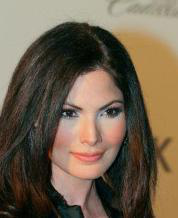

In [49]:
print(train_captions[3])
Image.open(f"../dataset/prep_data/{train_image_name[3]}")

In [64]:

encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

637it [16:55,  1.59s/it]
